In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from Gonzales import Gonzales
from math import sqrt
from collections import defaultdict

In [2]:
DATA_PATH = "data"

In [3]:
os.listdir(DATA_PATH)

['Team_Attributes.csv',
 'Player.csv',
 'Match.csv',
 'League.csv',
 'Country.csv',
 'Player_Attributes.csv',
 'Team.csv']

In [4]:
player_attr_raw = pd.read_csv(os.path.join(DATA_PATH, 'Player_Attributes.csv'))
player_attr_raw.shape

(183978, 42)

In [5]:
player_attr = player_attr_raw.dropna()
player_attr.shape

(180354, 42)

In [6]:
unique_foot = player_attr['preferred_foot'].unique()


In [7]:

unqiue_off_rate = player_attr['attacking_work_rate'].unique()


In [8]:

unqiue_def_rate = player_attr['defensive_work_rate'].unique()

In [9]:
player_attr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180354 entries, 0 to 183977
Data columns (total 42 columns):
id                     180354 non-null int64
player_fifa_api_id     180354 non-null int64
player_api_id          180354 non-null int64
date                   180354 non-null object
overall_rating         180354 non-null float64
potential              180354 non-null float64
preferred_foot         180354 non-null object
attacking_work_rate    180354 non-null object
defensive_work_rate    180354 non-null object
crossing               180354 non-null float64
finishing              180354 non-null float64
heading_accuracy       180354 non-null float64
short_passing          180354 non-null float64
volleys                180354 non-null float64
dribbling              180354 non-null float64
curve                  180354 non-null float64
free_kick_accuracy     180354 non-null float64
long_passing           180354 non-null float64
ball_control           180354 non-null float64
accele

In [10]:
vectorized_players_df = player_attr.drop(columns=['id','player_fifa_api_id',
                                               'player_api_id', 'date', 
                                               'preferred_foot', 'attacking_work_rate',
                                               'defensive_work_rate', 'overall_rating',
                                            'potential'])

In [11]:
vectorized_players_df.shape

(180354, 33)

In [12]:
description = vectorized_players_df.describe()
vectorized_players_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180354 entries, 0 to 183977
Data columns (total 33 columns):
crossing              180354 non-null float64
finishing             180354 non-null float64
heading_accuracy      180354 non-null float64
short_passing         180354 non-null float64
volleys               180354 non-null float64
dribbling             180354 non-null float64
curve                 180354 non-null float64
free_kick_accuracy    180354 non-null float64
long_passing          180354 non-null float64
ball_control          180354 non-null float64
acceleration          180354 non-null float64
sprint_speed          180354 non-null float64
agility               180354 non-null float64
reactions             180354 non-null float64
balance               180354 non-null float64
shot_power            180354 non-null float64
jumping               180354 non-null float64
stamina               180354 non-null float64
strength              180354 non-null float64
long_shots     

In [13]:
vectorized_players = vectorized_players_df.values

In [14]:
ranking_wgt_vector = np.array([
    -3,-3,-3,-1,-1, # Crossing, Finishing, Heading, Short Pass, Volleys
    0.1,0,0,0,0.1, # Dribbling, Curve, FK, Long Passing, Ball Control
    -0.3,0,0,0,0, # Acceleration, Sprint Speed, Agility, Reactions, Balance
    0,-0.1,0.5,0,0.3, # Shot Power, Jumping, Stamina, Strength, Long Shots
    -0.5,0.5,0.5,0,-0.1, # Aggression, Intereptions, Position, Vision, Penalties
    2,2,2, # Marking, Standing Tackle, Sliding Tackle
    5,5,5,5,5, # GK Diving, Handling, Kicking, Positioning, Reflexes
])
ranking_wgt_vector.shape

(33,)

In [15]:
def plot_clusters(clustered_data):
    plt.scatter(np.sum(clustered_data, axis=1), [0]*len(clustered_data[:,-1]), c=clustered_data[:,-1])
    plt.show()

In [16]:
temp = np.dot(vectorized_players, np.diag(ranking_wgt_vector))
print(temp.shape)

(180354, 33)


# Gonzales Clustering

In [17]:

clusters, three_cen_cost, three_mean_cost, centers = Gonzales(temp, temp[0,:], k=3)

In [18]:
clusters.shape

(180354, 34)

In [19]:
centers

array([[-147. , -132. , -213. ,  -61. ,  -44. ,    5.1,    0. ,    0. ,
           0. ,    4.9,  -18. ,    0. ,    0. ,    0. ,    0. ,    0. ,
          -5.8,   27. ,    0. ,   10.5,  -35.5,   35. ,   22.5,    0. ,
          -4.8,  130. ,  138. ,  138. ,   30. ,   55. ,   50. ,   40. ,
          40. ],
       [ -27. ,  -30. ,  -24. ,  -23. ,   -7. ,    0.9,    0. ,    0. ,
           0. ,    2.2,  -18.6,    0. ,    0. ,    0. ,    0. ,    0. ,
          -7.5,   28. ,    0. ,    2.7,  -40.5,   45. ,    7. ,    0. ,
          -8.8,   16. ,   16. ,   18. ,  455. ,  465. ,  380. ,  480. ,
         465. ],
       [ -36. ,  -21. ,  -24. ,  -23. ,   -8. ,    0.9,    0. ,    0. ,
           0. ,    1.8,  -11.7,    0. ,    0. ,    0. ,    0. ,    0. ,
          -6.3,   17.5,    0. ,    3.6,  -20.5,    6.5,    7.5,    0. ,
          -2.3,   18. ,   18. ,   16. ,  210. ,  305. ,  285. ,  135. ,
         210. ]])

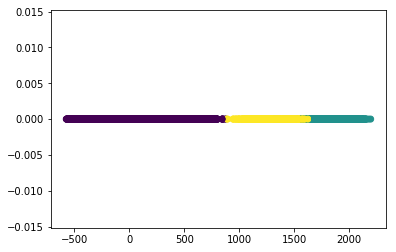

In [20]:
plot_clusters(clusters)

# KMeans++

In [21]:
def dist(a,b):
    return np.linalg.norm(a-b)

def KPP(data, c1, k=3):
    n = len(data)
    
    assignments = dict([(_, 0) for _ in range(n)])
    clusters = np.empty([k,len(c1)])
    clusters[0, :] = c1
    
    for i in range(1,k):
        weights = np.array([dist(d, clusters[assignments[idx], :])**2 for idx,d in enumerate(data)])
        weights = weights/sum(weights)
        centerIdx = np.random.choice(list(range(n)), p=weights)
        clusters[i,:] = data[centerIdx,:]
        for j in range(n):
            if dist(data[j,:], clusters[assignments[j], :]) > dist(data[j,:], clusters[i,:]):
                assignments[j] = i
    arr = [dist(d, clusters[assignments[idx],:]) for idx,d in enumerate(data)]
    max3cenCost = max(arr)
    mean3Cost = sqrt(sum([x**2 for x in arr])/len(arr))
   
    data = np.append(data, np.array([[i] for i in list(assignments.values())]), axis=1)
    return data, max3cenCost, mean3Cost, clusters

In [22]:
kmpp_clusters, kmpp_three_cen_cost, kmpp_three_mean_cost, kmm_centers = KPP(temp, temp[0,:], k=3)

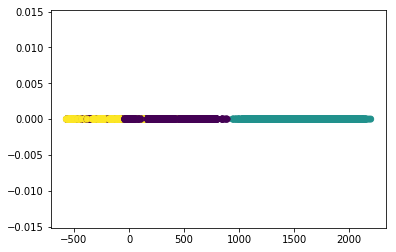

In [23]:
plot_clusters(kmpp_clusters)

# Lloyds

In [24]:
def Lloyds(data, init_centers, k=3, r=10):
    n = len(data)
    centers = np.copy(init_centers)
    assignments = defaultdict(list)
    for _ in range(r):
        old = np.copy(centers)
        clusterIdx = defaultdict(list)
        for i in range(n):
            d = data[i,:]
            minDist = np.argmin(np.apply_along_axis(dist, 1, centers, d))
            clusterIdx[minDist].append(i)
            assignments[i] = minDist
        for i in range(k):
            idxs = clusterIdx[i]
            subset = data[idxs, :]
            centers[i,:] = np.average(subset, axis=0)
        if np.allclose(old, centers):
            break
            
    arr = [dist(d, centers[assignments[idx],:]) for idx,d in enumerate(data)]
    max3cenCost = max(arr)
    mean3Cost = sqrt(sum([x**2 for x in arr])/len(data))
    data = np.append(data, np.array([[i] for i in list(assignments.values())]), axis=1)
   
    return data, max3cenCost, mean3Cost, centers

## Lloyds with KMeans++ centers

In [25]:
ll_clusters, ll_max3cenCost, ll_mean3Cost, ll_centers = Lloyds(temp, kmm_centers, k=3)

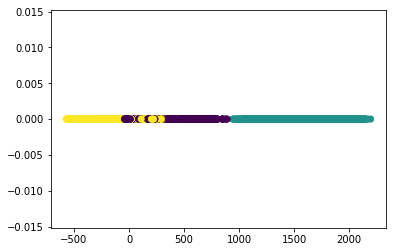

In [26]:
plot_clusters(ll_clusters)

## Lloyds with Gonzales centers

In [27]:
ll_g_clusters, ll_g_max3cenCost, ll_g_mean3Cost, ll_g_centers = Lloyds(temp,  centers, k=3)

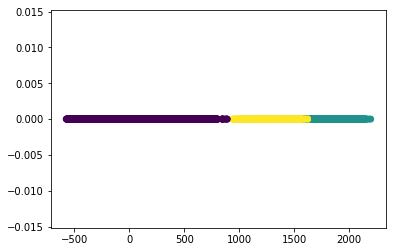

In [28]:
plot_clusters(ll_g_clusters)